In [9]:
import pandas as pd
from pymongo import MongoClient
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
conn = MongoClient('userver', 27017)
db = conn.ticker3_db

In [84]:
d = datetime(year=2019,month=1,day=1)
cursor  = db['kraken_orderdepth'].find({"timestamp":{"$gte":d}, "data.pair":"XXLMZUSD"}).limit(20000)
cursor.count(with_limit_and_skip=True)

20000

In [85]:
import collections

def flatten(d, parent_key='', sep='_'):
    items = []
    for k, v in d.items():
        new_key = parent_key + sep + k if parent_key else k
        if isinstance(v, collections.MutableMapping):
            items.extend(flatten(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

In [86]:
l = list()
for data in cursor:
    d = flatten(data['data'])
    d['timestamp'] = data['timestamp']
    l.append(d)


In [87]:
df = pd.DataFrame(l)

In [88]:
df['asks_price'] = df['asks_price'].apply(np.asfarray, np.float)
df['asks_volume'] = df['asks_volume'].apply(np.asfarray, np.float)
df['bids_price'] = df['bids_price'].apply(np.asfarray, np.float)
df['bids_volume'] = df['bids_volume'].apply(np.asfarray, np.float)

In [89]:
len(df)

20000

# 1. get original data, convert it to a format that is processable
# 2. walkt thru the dataset and add various calculations

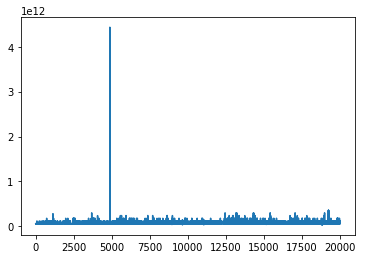

In [90]:
df['timestamp'].diff().plot()

In [43]:
import numpy as np

In [81]:
def myfunc(value):
    value['mid_price'] = (value['bids_price'][0]+value['asks_price'][0])/2
    l = np.sum(value['asks_price']*value['asks_volume']) + np.sum(value['bids_price']*value['bids_volume'])
    totvol = (np.sum(value['asks_volume'])+ np.sum(value['bids_volume']))
    value['imbalance'] = l/totvol - value['mid_price']
    return value

In [91]:
df = df.apply(myfunc, axis=1)

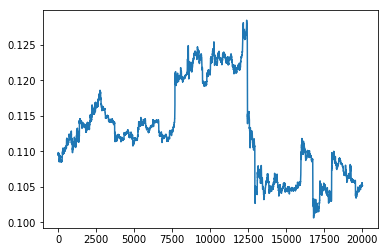

In [92]:
df['mid_price'].plot()

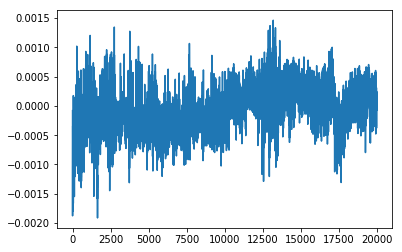

In [93]:
df['imbalance'].plot()

In [94]:
def changepoint(data, tresh:float, margin:float):
    df = pd.DataFrame()
    df['CS_HI'] = np.zeros(len(data))   # clear changepoint hi and lo
    df['CS_LO'] = np.zeros(len(data))
    df['detected'] = -1
    df['price'] = np.nan

    u0  = data.loc[0]  
    for i in range(1,len(data)):  # walt tru all datapoints
        df.loc[i, 'CS_HI'] = max(0.0, df.loc[i-1,'CS_HI'] + data.loc[i] - u0-margin)
        df.loc[i, 'CS_LO'] = max(0.0, df.loc[i-1,'CS_LO'] - data.loc[i] + u0-margin)
        if df.loc[i, 'CS_HI']> tresh:
            df.loc[i, 'detected'] = 1
        elif df.loc[i, 'CS_LO']> tresh:
            df.loc[i, 'detected'] = 0
        if df.loc[i, 'detected'] != -1: # if tresh is exeded, reset the cumsum and startingpoint
            df.loc[i,'price'] = data.loc[i]
            u0 = data.loc[i]  # set new U0
            df.loc[i,'CS_HI'] = 0 # set cumsum to 0
            df.loc[i,'CS_LO'] = 0
            

    #plt.subplot(2,1,1)
    #data.plot(figsize=(15,8))
    #df[['CS_HI', 'CS_LO']].plot(figsize=(15,4))
    return df

In [95]:
df1 = changepoint(df['mid_price'], 0.01,0.0)

## Regression model
M$\Delta$ = $\alpha$ + $\beta$* *xi* + $\epsilon$
* M$\Delta$ = Price change between this detection and the next changepoint
* *xi* = 1 if upward was detected, 0 if downward was detected
* $\epsilon$ = noise


$\Delta$

In [96]:
df2 = df1[df1['detected']!=-1].copy()

In [97]:
df2['M_delta'] = df2['price'].diff(periods=-1)
df2

,CS_HI,CS_LO,detected,price,M_delta
84,0.0,0.0,0,0.108613,-0.000725
114,0.0,0.0,1,0.109338,0.000743
147,0.0,0.0,0,0.108595,-0.000643
278,0.0,0.0,1,0.109238,-0.000820
305,0.0,0.0,1,0.110058,0.000283
376,0.0,0.0,0,0.109775,-0.000516
402,0.0,0.0,1,0.110291,-0.000204
525,0.0,0.0,1,0.110495,-0.001138
562,0.0,0.0,1,0.111633,0.000496
629,0.0,0.0,0,0.111137,-0.000469


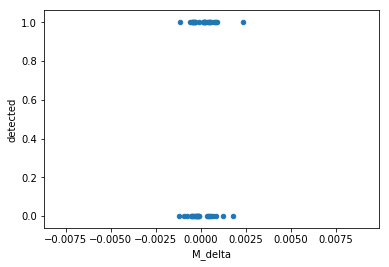

In [65]:
df2.plot.scatter(x='M_delta', y='detected')

In [48]:
import seaborn as sns

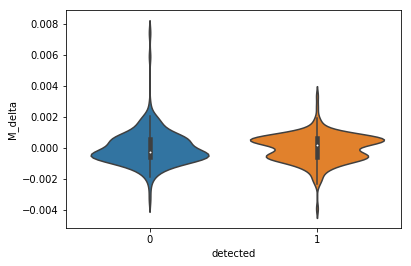

In [98]:
sns.violinplot(data=df2,y='M_delta', x='detected')

In [103]:
import collections

def mid_and_imbalance(value):
    value['mid_price'] = (value['bids_price'][0]+value['asks_price'][0])/2
    l = np.sum(value['asks_price']*value['asks_volume']) + np.sum(value['bids_price']*value['bids_volume'])
    totvol = (np.sum(value['asks_volume'])+ np.sum(value['bids_volume']))
    value['imbalance'] = l/totvol - value['mid_price']
    return value

def flatten(d, parent_key='', sep='_'):
    items = []
    for k, v in d.items():
        new_key = parent_key + sep + k if parent_key else k
        if isinstance(v, collections.MutableMapping):
            items.extend(flatten(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

def get_order_depth(pair:str, start_date:datetime, num_items):
    
    print('Connecting To MongoDB')
    conn = MongoClient('userver', 27017)
    db = conn.ticker3_db
    # make query
    d = datetime(year=2019,month=1,day=1)
    cursor  = db['kraken_orderdepth'].find({"timestamp":{"$gte":start_date}, "data.pair":pair}).limit(num_items)
    print(f'found {cursor.count(with_limit_and_skip=True)} items')
    
    print('flatten array')
    # flatten the data and make a list
    l = list()
    for data in cursor:
        d = flatten(data['data'])
        d['timestamp'] = data['timestamp']
        l.append(d)
        
    # create dataframe and convert strings to floats
    df = pd.DataFrame(l)
    df['asks_price'] = df['asks_price'].apply(np.asfarray, np.float)
    df['asks_volume'] = df['asks_volume'].apply(np.asfarray, np.float)
    df['bids_price'] = df['bids_price'].apply(np.asfarray, np.float)
    df['bids_volume'] = df['bids_volume'].apply(np.asfarray, np.float)
    
    print('Adding extra columns')
    df = df.apply(mid_and_imbalance, axis=1)
    print('Done')
    
    return df

In [105]:
df_xlm = get_order_depth(pair="XXLMZUSD", start_date=datetime(year=2019,month=1,day=1), num_items=20000)

Connecting To MongoDB
found 20000 items
flatten array
Adding extra columns
Done


In [ ]:
# göra en enkel modell för denna data?
